## Intro to deep learning for medical imaging, by [md.ai](https://www.md.ai)

## Lesson 2. Lung X-Rays Semantic Segmentation

**MISSING DESCRIPTION* 

The MD.ai annotator is used to view the DICOM images, and to create the image level annotation. The MD.ai python client library is then used to download images and annotations, prepare the datasets, then are then used to train the model for classification. 

- Original Dataset URL: 
- MD.ai annotator project URL: https://public.md.ai/annotator/project/
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai/

**Clink [here](https://colab) to launch this notebook on Google Colab.**
**How to use on Colab: in the menu, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.**

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [1]:
#!pip install --upgrade mdai

In [2]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

import skimage.io
import skimage.measure
from tqdm import tqdm
from PIL import Image

In [3]:
MODULE_DIR = os.path.abspath('../mdai-client-py')
sys.path.append(MODULE_DIR)

import mdai
import importlib
importlib.reload(mdai)

mdai.__version__

/home/tian/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


'0.0.4'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [4]:
mdai_client = mdai.Client(domain='staging.md.ai', access_token="16f1708f9f2de8f39e07a0b022e27473")

Successfully authenticated to staging.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `XXXX` for `https://public.md.ai/annotator/project/XXXX`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [5]:
p = mdai_client.project('ZWBD3qE6', path='/data/Lesson2')

Using path '/data/Lesson2' for data.
Preparing annotations export for project ZWBD3qE6...                                                
Preparing images export for project ZWBD3qE6...                                                     
Using cached images data for project ZWBD3qE6.
Using cached annotations data for project ZWBD3qE6.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [6]:
p.show_label_groups()

Label Group, Id: G_8q9, Name: Default group
	Labels:
	Id: L_yj7, Name: Lung



In [7]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_yj7':1 # Lung   
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_yj7': 1}


### Create the *Training* and *Validation* datasets

In [8]:
p.show_datasets() 

Datasets:
Id: D_grw, Name: Montgomery County 



In [9]:
dataset = p.get_dataset_by_id('D_grw')
dataset.prepare()

In [10]:
image_ids = dataset.get_image_ids()
len(image_ids)

138

### Display a few images

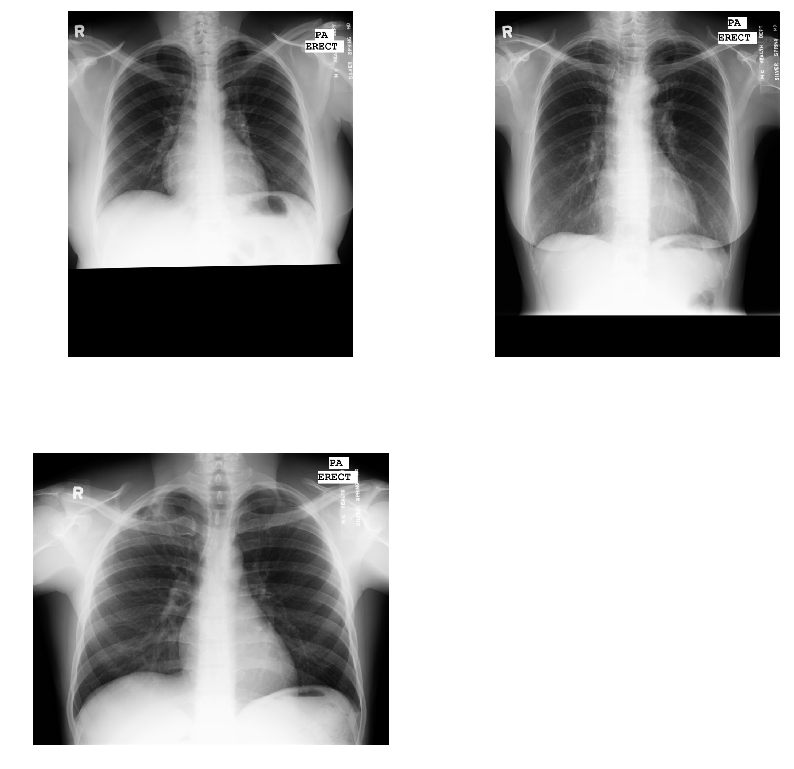

In [11]:
# visualize a few train images 
mdai.visualize.display_images(image_ids[:3], cols=2)

In [12]:
annotations = dataset.get_annotations()

In [13]:
imgs_anns_dict = dataset.imgs_anns_dict

In [14]:
#img = mdai.visualize.load_dicom_image(fp, to_RGB=True)
# img_width = annotations[0]['width']
# img_height = annotations[0]['height']
# num_images = len(dataset.get_image_ids())
# print(img_width, img_height, num_images)

In [15]:
from lesson2 import dataset
from lesson2 import dilated_unet
from lesson2 import train

import importlib

importlib.reload(dataset)
importlib.reload(dilated_unet)
importlib.reload(train)

Using TensorFlow backend.


<module 'lesson2.train' from '/home/tian/mdai-git/ml-lessons/lesson2/train.py'>

In [16]:
images, masks = dataset.load_images(imgs_anns_dict)

(-0.5, 127.5, 127.5, -0.5)

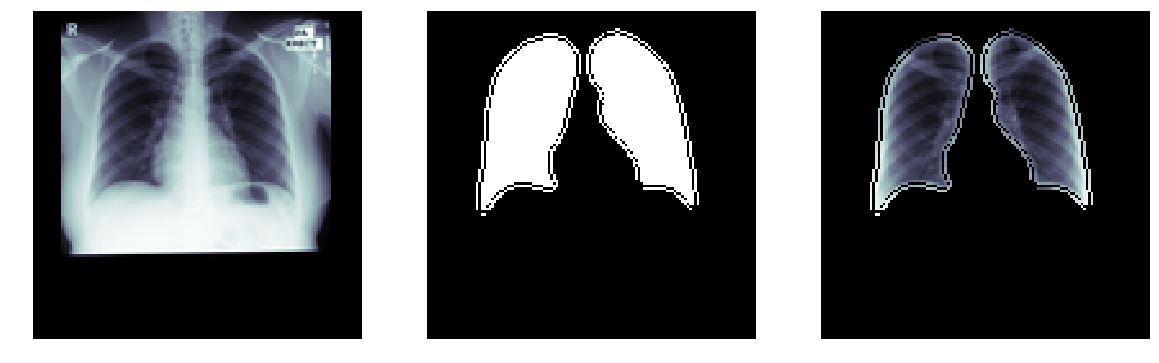

In [17]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(images[0,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(masks[0,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.bitwise_and(images[0,:,:,0], images[0,:,:,0], mask=masks[0,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

In [41]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [76]:
CONFIG_FP = 'lesson2/configs/6.json'
name = os.path.basename(CONFIG_FP).split('.')[0]

In [77]:
with open(CONFIG_FP, 'r') as f:
    config = json.load(f)
history = train.train(config, name, images, masks)

Epoch 1/1000
 - 2s - loss: 0.5779 - acc: 0.7361 - dice: 0.0417 - iou: 0.0478 - val_loss: 0.5262 - val_acc: 0.7407 - val_dice: 2.4990e-04 - val_iou: 1.2497e-04

Epoch 00001: val_loss improved from inf to 0.52618, saving model to /home/tian/mdai-git/ml-lessons/lesson2/../trained/model_6.hdf5
Epoch 2/1000
 - 1s - loss: 0.4631 - acc: 0.7734 - dice: 2.8817e-04 - iou: 1.4411e-04 - val_loss: 0.5293 - val_acc: 0.7407 - val_dice: 2.4990e-04 - val_iou: 1.2497e-04

Epoch 00002: val_loss did not improve from 0.52618
Epoch 3/1000
 - 1s - loss: 0.4417 - acc: 0.7748 - dice: 3.0539e-04 - iou: 1.5272e-04 - val_loss: 0.5133 - val_acc: 0.7407 - val_dice: 2.4990e-04 - val_iou: 1.2497e-04

Epoch 00003: val_loss improved from 0.52618 to 0.51329, saving model to /home/tian/mdai-git/ml-lessons/lesson2/../trained/model_6.hdf5
Epoch 4/1000
 - 2s - loss: 0.4281 - acc: 0.7718 - dice: 0.0112 - iou: 0.0033 - val_loss: 0.5634 - val_acc: 0.7472 - val_dice: 0.2615 - val_iou: 0.1020

Epoch 00004: val_loss did not impro

 - 1s - loss: 0.2970 - acc: 0.8702 - dice: 0.6670 - iou: 0.4730 - val_loss: 0.4212 - val_acc: 0.8281 - val_dice: 0.6298 - val_iou: 0.4065

Epoch 00037: val_loss did not improve from 0.38568
Epoch 38/1000
 - 1s - loss: 0.2928 - acc: 0.8695 - dice: 0.6864 - iou: 0.5245 - val_loss: 0.3873 - val_acc: 0.8373 - val_dice: 0.6664 - val_iou: 0.4760

Epoch 00038: val_loss did not improve from 0.38568
Epoch 39/1000
 - 1s - loss: 0.3014 - acc: 0.8684 - dice: 0.6797 - iou: 0.4973 - val_loss: 0.4236 - val_acc: 0.8271 - val_dice: 0.6156 - val_iou: 0.3760

Epoch 00039: val_loss did not improve from 0.38568
Epoch 40/1000
 - 1s - loss: 0.3025 - acc: 0.8706 - dice: 0.6784 - iou: 0.4842 - val_loss: 0.3987 - val_acc: 0.8296 - val_dice: 0.6806 - val_iou: 0.5671

Epoch 00040: val_loss did not improve from 0.38568
Epoch 41/1000
 - 1s - loss: 0.3122 - acc: 0.8618 - dice: 0.6814 - iou: 0.5312 - val_loss: 0.3967 - val_acc: 0.8301 - val_dice: 0.6342 - val_iou: 0.4082

Epoch 00041: val_loss did not improve from 0.


Epoch 00075: val_loss did not improve from 0.35462
Epoch 76/1000
 - 1s - loss: 0.2761 - acc: 0.8774 - dice: 0.7187 - iou: 0.5539 - val_loss: 0.3770 - val_acc: 0.8432 - val_dice: 0.7016 - val_iou: 0.5847

Epoch 00076: val_loss did not improve from 0.35462
Epoch 77/1000
 - 2s - loss: 0.2688 - acc: 0.8787 - dice: 0.7130 - iou: 0.5743 - val_loss: 0.3731 - val_acc: 0.8393 - val_dice: 0.6907 - val_iou: 0.5587

Epoch 00077: val_loss did not improve from 0.35462
Epoch 78/1000
 - 1s - loss: 0.2722 - acc: 0.8806 - dice: 0.7126 - iou: 0.5472 - val_loss: 0.3598 - val_acc: 0.8490 - val_dice: 0.7022 - val_iou: 0.5565

Epoch 00078: val_loss did not improve from 0.35462
Epoch 79/1000
 - 1s - loss: 0.2805 - acc: 0.8743 - dice: 0.7133 - iou: 0.5570 - val_loss: 0.3538 - val_acc: 0.8453 - val_dice: 0.7039 - val_iou: 0.5817

Epoch 00079: val_loss improved from 0.35462 to 0.35383, saving model to /home/tian/mdai-git/ml-lessons/lesson2/../trained/model_6.hdf5
Epoch 80/1000
 - 1s - loss: 0.2726 - acc: 0.8778

dict_keys(['val_loss', 'val_acc', 'val_dice', 'val_iou', 'loss', 'acc', 'dice', 'iou'])


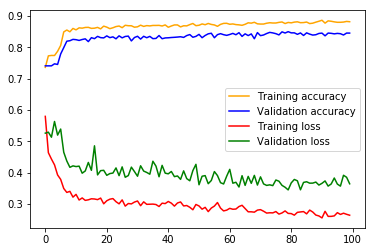

In [78]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [79]:
from keras.models import load_model
import keras.backend as K

model_name = 'trained/model_'+name+'.hdf5'
print(model_name)
model = load_model(model_name, custom_objects={'dice': train.dice, 'iou': train.iou})

trained/model_6.hdf5


Text(0.5,1,'Predicted Lung Segmentation')

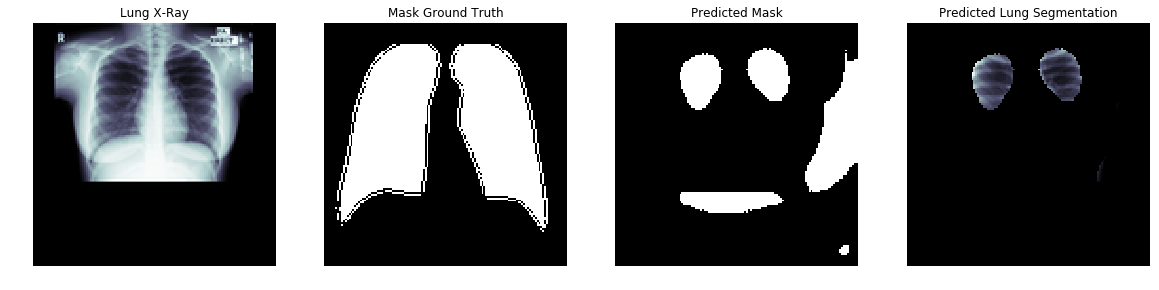

In [80]:
plt.figure(figsize=(20, 10))

img_index = random.choice(range(images.shape[0]))

plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Mask Ground Truth')

random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
mask = model.predict(random_img_2)[0][:,:,0] > 0.5
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')

In [81]:
model.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 128, 128, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 128, 128, 16) 0           conv2d_66[0][0]                  
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 128, 128, 16) 2320        activation_66[0][0]              
__________________________________________________________________________________________________
activation